In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from lstm import LSTM

In [3]:
def create_sine_dataset(samples=100, seq_len=50):
    """
    Generates simple sine waves. 
    Analogy: Periodic chemical oscillation (Limit Cycles).
    """
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

In [23]:
samples = create_sine_dataset(1000,50)
samples.size()

torch.Size([1000, 50, 1])

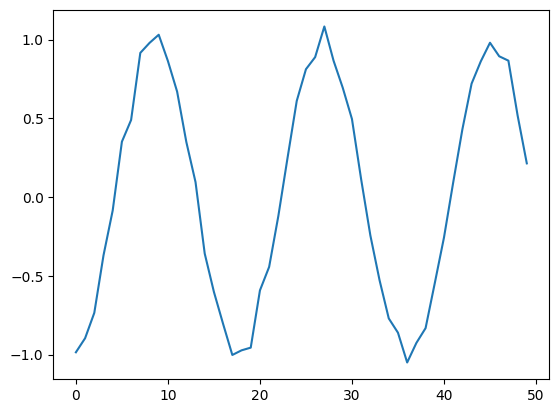

In [25]:
plt.plot(samples[0,:,0])

In [4]:
def train_lstm(model, data, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    print("--- Training LSTM ---")
    model.train()
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()

        #print(data[0, :, :].size())
        predictions, _ = model(data)
        
        # Target: We want the model to predict the NEXT step.
        # Input at t should predict Data at t+1.
        # We crop the last prediction and the first data point to align them.
        preds_shifted = predictions[:, :-1, :]
        targets_shifted = data[:, 1:, :]
        
        loss = criterion(preds_shifted, targets_shifted)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {loss.item():.5f}")
            
    return losses

--- Training LSTM ---
Epoch 0: Loss 0.56817
Epoch 10: Loss 0.34252
Epoch 20: Loss 0.20783
Epoch 30: Loss 0.13430
Epoch 40: Loss 0.09931
Epoch 50: Loss 0.08472
Epoch 60: Loss 0.07742
Epoch 70: Loss 0.07267
Epoch 80: Loss 0.06927
Epoch 90: Loss 0.06669
Epoch 100: Loss 0.06455
Epoch 110: Loss 0.06262
Epoch 120: Loss 0.06084
Epoch 130: Loss 0.05920
Epoch 140: Loss 0.05768
Epoch 150: Loss 0.05627
Epoch 160: Loss 0.05496
Epoch 170: Loss 0.05375
Epoch 180: Loss 0.05263
Epoch 190: Loss 0.05159
Epoch 200: Loss 0.05063
Epoch 210: Loss 0.04975
Epoch 220: Loss 0.04893
Epoch 230: Loss 0.04817
Epoch 240: Loss 0.04748
Epoch 250: Loss 0.04684
Epoch 260: Loss 0.04625
Epoch 270: Loss 0.04571
Epoch 280: Loss 0.04521
Epoch 290: Loss 0.04476
Epoch 300: Loss 0.04434
Epoch 310: Loss 0.04396
Epoch 320: Loss 0.04361
Epoch 330: Loss 0.04329
Epoch 340: Loss 0.04299
Epoch 350: Loss 0.04272
Epoch 360: Loss 0.04248
Epoch 370: Loss 0.04225
Epoch 380: Loss 0.04204
Epoch 390: Loss 0.04185
Epoch 400: Loss 0.04167
Epoch

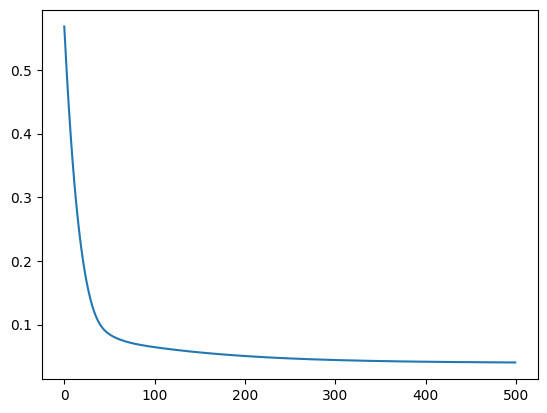

In [ ]:
lstm_data = create_sine_dataset(samples=10000)
lstm_model = LSTM()
losses = train_lstm(lstm_model, lstm_data, epochs=500)
plt.plot(losses)

In [8]:
def generate_sequence(model, seed_data, future_steps=50):
    """
    Uses the trained model to generate future steps based on a seed sequence.
    
    Args:
        model: The trained LSTM model
        seed_data: Tensor of shape [1, Seq_Len, Input_Size] (a single sequence)
        future_steps: How many steps to generate
        
    Returns:
        generated_seq: Tensor of shape [1, Future_Steps, Input_Size]
    """
    model.eval()
    
    # Initialize internal state
    h = torch.zeros(1, model.hidden_size).to(seed_data.device)
    c = torch.zeros(1, model.hidden_size).to(seed_data.device)
    
    generated_values = []
    
    with torch.no_grad():
        # 1. Warm up the internal state (h, c) using the seed data
        seq_len = seed_data.size(1)
        for t in range(seq_len):
            x_t = seed_data[:, t, :] # Shape (1, Input_Size)
            h, c, _ = model.cell(x_t, h, c)
        
        # The model is now primed. The last 'h' contains the memory of the seed.
        # We make the first prediction.
        current_input = model.predictor(h) 
        generated_values.append(current_input)
        
        # 2. Autoregressive Generation Loop
        for _ in range(future_steps - 1):
            # Feed the LAST PREDICTION as the NEXT INPUT
            h, c, _ = model.cell(current_input, h, c)
            pred = model.predictor(h)
            
            generated_values.append(pred)
            current_input = pred # Update input for next step
            
    return torch.stack(generated_values, dim=1)

In [28]:
# 1. Create Data
lstm_data = create_sine_dataset(samples=100)

# 2. Train
lstm_model = LSTM(input_size=1, hidden_size=16)
train_lstm(lstm_model, lstm_data, epochs=1000)

# 3. Generate New Data
print("\n--- Generating Future Sequence ---")

# Use the first sample from our dataset as a "seed"
seed_sample = lstm_data[0:1, :, :] # Shape [1, 50, 1]

future_steps = 20
generated = generate_sequence(lstm_model, seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Generated shape: {generated.shape}")
print(f"First 5 generated values: {generated[0, :, 0].numpy()}")

--- Training LSTM ---
Epoch 0: Loss 0.57828
Epoch 10: Loss 0.32979
Epoch 20: Loss 0.18362
Epoch 30: Loss 0.11688
Epoch 40: Loss 0.09322
Epoch 50: Loss 0.08395
Epoch 60: Loss 0.07749
Epoch 70: Loss 0.07253
Epoch 80: Loss 0.06892
Epoch 90: Loss 0.06610
Epoch 100: Loss 0.06371
Epoch 110: Loss 0.06162
Epoch 120: Loss 0.05977
Epoch 130: Loss 0.05811
Epoch 140: Loss 0.05660
Epoch 150: Loss 0.05522
Epoch 160: Loss 0.05397
Epoch 170: Loss 0.05282
Epoch 180: Loss 0.05177
Epoch 190: Loss 0.05080
Epoch 200: Loss 0.04992
Epoch 210: Loss 0.04912
Epoch 220: Loss 0.04838
Epoch 230: Loss 0.04771
Epoch 240: Loss 0.04709
Epoch 250: Loss 0.04652
Epoch 260: Loss 0.04600
Epoch 270: Loss 0.04552
Epoch 280: Loss 0.04508
Epoch 290: Loss 0.04467
Epoch 300: Loss 0.04430
Epoch 310: Loss 0.04395
Epoch 320: Loss 0.04364
Epoch 330: Loss 0.04334
Epoch 340: Loss 0.04307
Epoch 350: Loss 0.04282
Epoch 360: Loss 0.04258
Epoch 370: Loss 0.04236
Epoch 380: Loss 0.04216
Epoch 390: Loss 0.04197
Epoch 400: Loss 0.04179
Epoch

In [29]:
generated = generated = generate_sequence(lstm_model, seed_sample, future_steps=50)

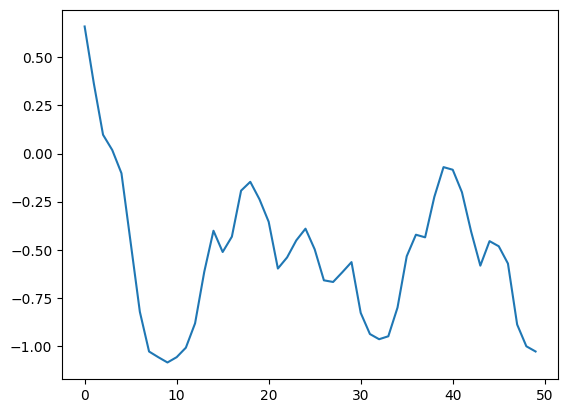

In [30]:
plt.plot(generated[0,:,0])

In [6]:
def train_ddpm(ddpm_model, data, epochs=50):
    optimizer = optim.Adam(ddpm_model.network.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    print("\n--- Training DDPM ---")
    ddpm_model.train()
    
    losses = []
    
    for epoch in range(epochs):
        avg_loss = 0
        # Simple batch processing (treating whole dataset as one batch for simplicity here)
        x0 = data 
        n = len(x0)
        
        optimizer.zero_grad()
        
        # 1. Sample random timesteps for each image in batch
        t = torch.randint(0, ddpm_model.n_steps, (n,))
        
        # 2. Generate random noise (The "Inhibitor" we want to predict)
        epsilon = torch.randn_like(x0)
        
        # 3. Add noise to image (Forward Diffusion)
        # Formula: x_t = sqrt(alpha_bar) * x0 + sqrt(1-alpha_bar) * epsilon
        a_bar = ddpm_model.alpha_bars[t].view(-1, 1, 1, 1)
        noisy_image = torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * epsilon
        
        # 4. Model attempts to predict the noise
        noise_pred = ddpm_model.network(noisy_image, t)
        
        # 5. Loss: How close was the predicted noise to the actual noise?
        loss = criterion(noise_pred, epsilon)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {loss.item():.5f}")

    return losses